In [3]:
from __future__ import annotations

import base64
from pathlib import Path
import mujoco
import mujoco.rollout as rollout
import numpy as np
from absl import logging
from mujoco import sysid
import mediapy as media
from matplotlib import pyplot as plt

logging.set_verbosity("INFO")

JOINT_NAMES = [
    "if_mcp",
    "if_rot",
    "if_pip",
    "if_dip",
    "mf_mcp",
    "mf_rot",
    "mf_pip",
    "mf_dip",
    "rf_mcp",
    "rf_rot",
    "rf_pip",
    "rf_dip",
    "th_cmc",
    "th_axl",
    "th_mcp",
    "th_ipl",
]

MJCF_PATH=Path("assets") / "leap_hand" / "mjcf" / "right_hand.xml"
OUTPUT_DIR=Path("results")

from IPython.display import IFrame

def display_report(report):
    html_b64 = base64.b64encode(report.build().encode()).decode()
    return IFrame(src=f"data:text/html;base64,{html_b64}", width="100%", height=800)

In [4]:
print(f"Loading model from {str(MJCF_PATH)}...")

spec = mujoco.MjSpec.from_file(str(MJCF_PATH))
model = spec.compile()
data = mujoco.MjData(model)

# -------------------------------------------------
# Time
# -------------------------------------------------
duration = 3.0
n_steps = int(duration / model.opt.timestep)
t = np.arange(n_steps) * model.opt.timestep

print(model.opt.timestep)

# -------------------------------------------------
# Start configuration (ALL joints)
# -------------------------------------------------
start_cfg = {
    "if_mcp": 0.0,
    "if_rot": 0.0,
    "if_pip": 0.0,
    "if_dip": 0.0,
    "mf_mcp": 0.0,
    "mf_rot": 0.0,
    "mf_pip": 0.0,
    "mf_dip": 0.0,
    "rf_mcp": 0.0,
    "rf_rot": 0.0,
    "rf_pip": 0.0,
    "rf_dip": 0.0,
    "th_cmc": 0.0,
    "th_axl": 0.0,
    "th_mcp": 0.0,
    "th_ipl": 0.0,
}

# -------------------------------------------------
# Control configuration (ONLY controlled joints)
# -------------------------------------------------
ctrl_cfg = {
    "if_mcp": {"low": 0.0, "high": 1.0},
    # "if_pip": {"low": 0.0, "high": 0.8},
    # "if_dip": {"low": 0.0, "high": 0.8},
}

# -------------------------------------------------
# Set initial qpos
# -------------------------------------------------
for joint_name, start_pos in start_cfg.items():
    joint_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_JOINT, joint_name
    )
    if joint_id == -1:
        raise ValueError(f"Joint {joint_name} not found in model")

    qpos_adr = model.jnt_qposadr[joint_id]
    data.qpos[qpos_adr] = start_pos

mujoco.mj_forward(model, data)

# -------------------------------------------------
# Create control signal
# -------------------------------------------------
ctrl = np.zeros((n_steps, model.nu))
freq = 0.5  # Hz
ctrlrange = model.actuator_ctrlrange.copy()

for joint_name, cfg in ctrl_cfg.items():

    actuator_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"{joint_name}_act"
    )

    if actuator_id == -1:
        raise ValueError(f"Actuator {joint_name}_act not found")

    start = start_cfg[joint_name]
    low = cfg["low"]
    high = cfg["high"]

    # Validate actuator limits
    if not (ctrlrange[actuator_id, 0] <= low <= ctrlrange[actuator_id, 1] and
            ctrlrange[actuator_id, 0] <= high <= ctrlrange[actuator_id, 1]):
        raise ValueError(
            f"{joint_name} low/high outside actuator limits "
            f"{ctrlrange[actuator_id]}"
        )

    # If constant signal
    if np.isclose(low, high):
        ctrl[:, actuator_id] = low
        continue

    # Sine wave between low and high
    amplitude = 0.5 * (high - low)
    offset = 0.5 * (high + low)

    # Phase so it starts at initial joint position
    phase = np.arcsin(np.clip((start - offset) / amplitude, -1.0, 1.0))

    ctrl[:, actuator_id] = offset + amplitude * np.sin(
        2 * np.pi * freq * t + phase
    )

    ctrl[:, actuator_id] = np.clip(
        ctrl[:, actuator_id],
        ctrlrange[actuator_id, 0],
        ctrlrange[actuator_id, 1],
    )

# -------------------------------------------------
# Rollout
# -------------------------------------------------
initial_state = sysid.create_initial_state(
    model, data.qpos, data.qvel, data.act
)

state, sensor = rollout.rollout(model, data, initial_state, ctrl)

state = np.squeeze(state, axis=0)
sensor = np.squeeze(sensor, axis=0)
times = state[:, 0]

# -------------------------------------------------
# Render
# -------------------------------------------------
frames = sysid.render_rollout(
    model, data, state[None], framerate=30, height=400, width=560
)

media.show_video(frames, fps=30)


Loading model from assets/leap_hand/mjcf/right_hand.xml...
0.002


sensor shape: (1500, 16)


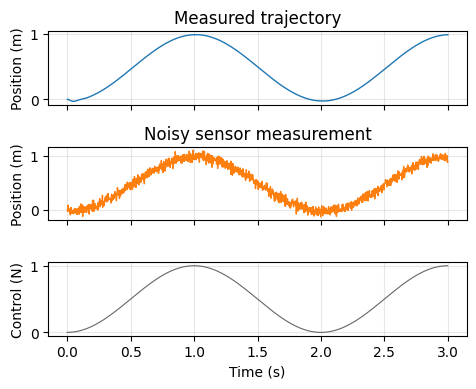

In [ ]:
# Add realistic sensor noise
rng = np.random.default_rng(seed=0)
noise_std = np.zeros(sensor.shape[1])
noise_std[:] = 0.05   # position noise (rad)
sensor_noisy = sensor + rng.normal(scale=noise_std, size=sensor.shape)

print("sensor shape:", sensor.shape)

control_ts = sysid.TimeSeries(t, ctrl)
sensor_ts = sysid.TimeSeries.from_names(times, sensor_noisy, model)

fig, axes = plt.subplots(3, 1, figsize=(5, 4), sharex=True,
                         gridspec_kw={"height_ratios": [2, 2, 2]})

axes[0].plot(times, sensor[:, 0], color="C0", linewidth=1.0)
axes[0].set_ylabel("Position (m)")
axes[0].set_title("Measured trajectory")

# plot noisey sensor data
axes[1].plot(times, sensor_noisy[:, 0], color="C1", linewidth=1.0)
axes[1].set_ylabel("Position (m)")
axes[1].set_title("Noisy sensor measurement")

axes[2].plot(t, ctrl[:, 0], color="0.4", linewidth=0.8)
axes[2].set_ylabel("Control (N)")
axes[2].set_xlabel("Time (s)")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
INIT_KP = 1.0
INIT_KV = -0.01

def make_armature_modifier(joint_name):
    """Create a modifier that sets armature on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).armature = param.value[0]
    return modifier

def make_joint_damping_modifier(joint_name):
    """Create a modifier that sets damping on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).damping = param.value[0]
    return modifier

def make_actuator_kp_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        print(f"Setting {actuator_name} kp to {param.value[0]}, originally {spec.actuator(actuator_name).gainprm[0]}")
        spec.actuator(actuator_name).gainprm[0] = param.value[0]
    return modifier

def make_actuator_kv_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        print(f"Setting {actuator_name} kv to {param.value[0]}, originally {spec.actuator(actuator_name).biasprm[2]}")
        spec.actuator(actuator_name).biasprm[2] = param.value[0]
    return modifier

params = sysid.ParameterDict()
for name in ctrl_cfg.keys():
    act_name = f"{name}_act"
    # get actuator actual kp and kv
    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, act_name)
    true_kp = model.actuator_gainprm[act_id, 0]
    true_kv = model.actuator_biasprm[act_id, 2]
    params.add(sysid.Parameter(
        f"{name}_kp",
        nominal=true_kp,
        min_value=0.0,
        max_value=5.0,
        modifier=make_actuator_kp_modifier(act_name),
    ))
    params[f"{name}_kp"].value[:] = INIT_KP
    params.add(sysid.Parameter(
        f"{name}_kv",
        nominal=true_kv,
        min_value=-1.0,
        max_value=0.0,
        modifier=make_actuator_kv_modifier(act_name),
    ))
    params[f"{name}_kv"].value[:] = INIT_KV

print("Initial parameter vector:", params.as_vector())

Initial parameter vector: [ 1.   -0.01]


In [ ]:
#@title { vertical-output: true}
ms = sysid.ModelSequences(
    "leap_hand", spec, "sinusoidal", initial_state, control_ts, sensor_ts,
)

residual_fn = sysid.build_residual_fn(models_sequences=[ms])

opt_params, opt_result = sysid.optimize(
    initial_params=params,
    residual_fn=residual_fn,
    optimizer="mujoco",
)

Setting if_mcp_act kp to 1.0, originally 3.0
Setting if_mcp_act kv to -0.01, originally -0.03
Setting if_mcp_act kp to 1.0000000149011612, originally 1.0
Setting if_mcp_act kv to -0.01, originally -0.01
Setting if_mcp_act kp to 1.0, originally 1.0000000149011612
Setting if_mcp_act kv to -0.009999985098838806, originally -0.01
Setting if_mcp_act kp to 2.9997104546684144, originally 1.0
Setting if_mcp_act kv to -0.01243267940965269, originally -0.009999985098838806
iter: 0    y: 14.9       log10mu: -inf  ratio: 1        dx: 2        reduction: 0.47   
Setting if_mcp_act kp to 2.9997104099692455, originally 2.9997104546684144
Setting if_mcp_act kv to -0.01243267940965269, originally -0.01243267940965269
Setting if_mcp_act kp to 2.9997104546684144, originally 2.9997104099692455
Setting if_mcp_act kv to -0.012432664508491497, originally -0.01243267940965269
Setting if_mcp_act kp to 2.9883087939524193, originally 2.9997104546684144
Setting if_mcp_act kv to -0.014227020199887494, originally -

INFO:absl:
+----------------------+-----------+-----------+--------------+-------------+-------------+-------------+-----------+-----------+-----------+
| Parameter            | Initial   | Nominal   | Identified   | Lower       | Upper       | Abs Err     | Abs Del   | Rel Err   | Rel Del   |
+======================+===========+===========+==============+=============+=============+=============+===========+===========+===========+
| if_mcp_kp            |  1.0000   |  3.0000   |  2.9968      |  0.0000e+00 |  5.0000     |  3.1709e-03 |  1.9968   | 0.1%      | 199.7%    |
| if_mcp_kv            | -0.0100   | -0.0300   | -0.0319      | -1.0000     |  0.0000e+00 |  1.8744e-03 |  0.0219   | 6.2%      | 218.7%    |
+----------------------+-----------+-----------+--------------+-------------+-------------+-------------+-----------+-----------+-----------+
RMSE: 0.002605
RMS Delta: 1.412


Setting if_mcp_act kp to 2.996829111701745, originally 2.996829111701745
Setting if_mcp_act kv to -0.03187438495882557, originally -0.03187438495882557
Setting if_mcp_act kp to 2.996829128132719, originally 2.996829111701745
Setting if_mcp_act kv to -0.031874396126363, originally -0.03187438495882557
iter: 11   y: 14.43      log10mu: -0.7  ratio: 1.5      dx: 4.5e-08  reduction: 1.8e-15
Setting if_mcp_act kp to 2.9968290834764852, originally 2.996829128132719
Setting if_mcp_act kv to -0.031874396126363, originally -0.031874396126363
Setting if_mcp_act kp to 2.996829128132719, originally 2.9968290834764852
Setting if_mcp_act kv to -0.03187438122520181, originally -0.031874396126363
Setting if_mcp_act kp to 2.9968290834764852, originally 2.996829128132719
Setting if_mcp_act kv to -0.031874396126363, originally -0.03187438122520181
Setting if_mcp_act kp to 2.996829128132719, originally 2.9968290834764852
Setting if_mcp_act kv to -0.03187438122520181, originally -0.031874396126363
Terminat

In [ ]:
report = sysid.default_report(
    models_sequences=[ms],
    initial_params=params,
    opt_params=opt_params,
    residual_fn=residual_fn,
    opt_result=opt_result,
    title="Leap Hand Identification",
    save_path=OUTPUT_DIR,
)
display_report(report)

Setting if_mcp_act kp to 1.0, originally 2.996829128132719
Setting if_mcp_act kv to -0.01, originally -0.03187438122520181
Setting if_mcp_act kp to 3.0, originally 2.996829128132719
Setting if_mcp_act kv to -0.03, originally -0.03187438122520181
Setting if_mcp_act kp to 2.996829128132719, originally 2.996829128132719
Setting if_mcp_act kv to -0.031874396126363, originally -0.03187438122520181
Setting if_mcp_act kp to 1.0, originally 2.996829128132719
Setting if_mcp_act kv to -0.01, originally -0.03187438122520181
Setting if_mcp_act kp to 3.0, originally 2.996829128132719
Setting if_mcp_act kv to -0.03, originally -0.03187438122520181
Setting if_mcp_act kp to 3.0, originally 2.996829128132719
Setting if_mcp_act kv to -0.03, originally -0.03187438122520181
Setting if_mcp_act kp to 2.996829128132719, originally 2.996829128132719
Setting if_mcp_act kv to -0.031874396126363, originally -0.03187438122520181
Setting if_mcp_act kp to 1.0, originally 2.996829128132719
Setting if_mcp_act kv to -